# AT3 - XGBoost

In [12]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import dump
from catboost import CatBoostRegressor
from imblearn.over_sampling import SMOTE
from hyperopt import fmin, tpe, hp, Trials
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split

In [2]:
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

In [8]:
X_train.head()

,startingAirport,destinationAirport,cabin_type,year,month,day,hour,minute
0,LAX,PHL,coach,2022,4,17,0,4
1,LAX,BOS,coach,2022,4,17,0,4
2,LAX,DFW,coach,2022,4,17,0,4
3,LAX,LGA,coach,2022,4,17,0,4
4,LAX,ATL,coach,2022,4,17,0,4


In [11]:
# Cyclical encoding for time features (hour and month)
def encode_cyclical_features(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute'])  # Drop raw datetime features after encoding
    return df

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['startingAirport', 'destinationAirport', 'cabin_type']),
        ('cyclical', FunctionTransformer(encode_cyclical_features), ['year', 'month', 'day', 'hour', 'minute'])
    ], remainder='passthrough'
)

# Define pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', eta=0.1, max_depth=6, random_state=42))
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Predictions
train_pred = pipeline.predict(X_train)
val_pred = pipeline.predict(X_val)
test_pred = pipeline.predict(X_test)

# Calculate and print RMSE and MAE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

train_rmse, train_mae = calculate_metrics(y_train, train_pred)
val_rmse, val_mae = calculate_metrics(y_val, val_pred)
test_rmse, test_mae = calculate_metrics(y_test, test_pred)

print(f"Training Set - RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print(f"Validation Set - RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
print(f"Test Set - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")

Training Set - RMSE: 158.69, MAE: 110.86
Validation Set - RMSE: 170.96, MAE: 117.79
Test Set - RMSE: 157.78, MAE: 113.30


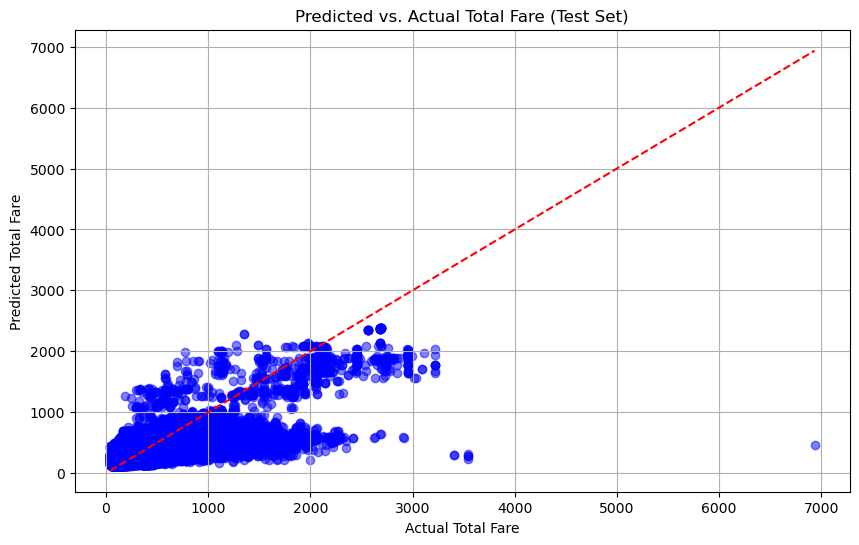

In [13]:
# Plot predicted vs. actual totalFare for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Total Fare")
plt.ylabel("Predicted Total Fare")
plt.title("Predicted vs. Actual Total Fare (Test Set)")
plt.grid(True)
plt.show()

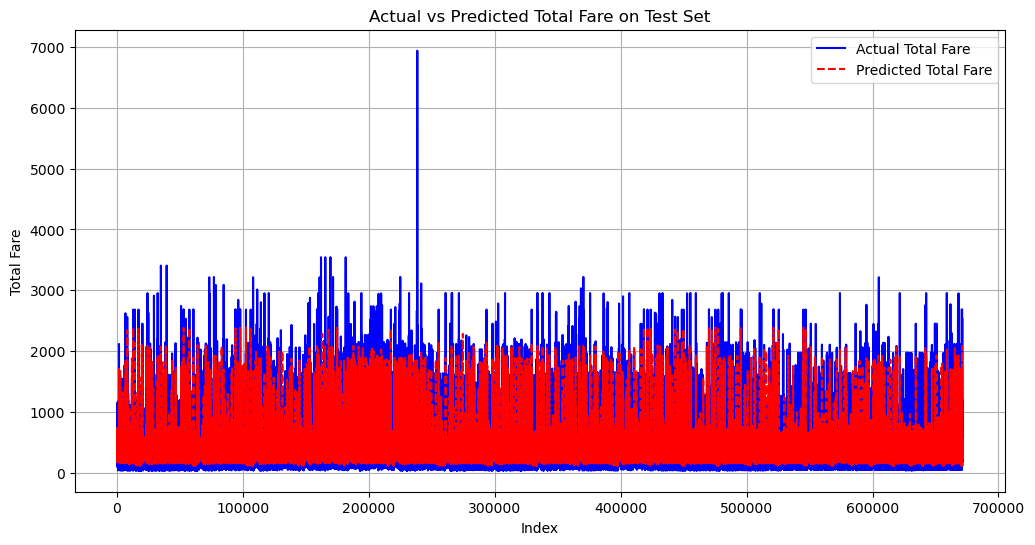

In [15]:
# Plot actual vs. predicted totalFare values with index on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Total Fare", color="blue", linestyle="-")
plt.plot(test_pred, label="Predicted Total Fare", color="red", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Total Fare")
plt.title("Actual vs Predicted Total Fare on Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
dump(pipeline,  '../models/xgboost_simpel.joblib')

['../models/xgboost_simpel.joblib']

In [19]:
# Define categorical columns to be one-hot encoded
categorical_cols = ['startingAirport', 'destinationAirport', 'cabin_type']

# Define preprocessor for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Define XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Fit the model on training data
model_pipeline.fit(X_train, y_train)

# Predict on train, validation, and test sets
train_pred = model_pipeline.predict(X_train)
val_pred = model_pipeline.predict(X_val)
test_pred = model_pipeline.predict(X_test)

# Calculate RMSE and MAE for each set
metrics = {
    'Train RMSE': mean_squared_error(y_train, train_pred, squared=False),
    'Train MAE': mean_absolute_error(y_train, train_pred),
    'Validation RMSE': mean_squared_error(y_val, val_pred, squared=False),
    'Validation MAE': mean_absolute_error(y_val, val_pred),
    'Test RMSE': mean_squared_error(y_test, test_pred, squared=False),
    'Test MAE': mean_absolute_error(y_test, test_pred)
}

# Print out metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Train RMSE: 139.54
Train MAE: 94.01
Validation RMSE: 173.04
Validation MAE: 120.50
Test RMSE: 161.39
Test MAE: 117.37


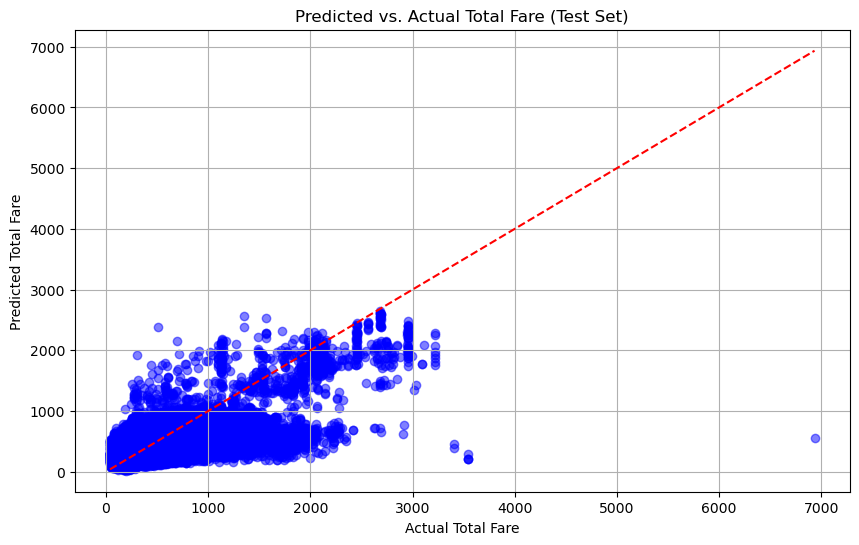

In [21]:
# Plot predicted vs. actual totalFare for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Total Fare")
plt.ylabel("Predicted Total Fare")
plt.title("Predicted vs. Actual Total Fare (Test Set)")
plt.grid(True)
plt.show()

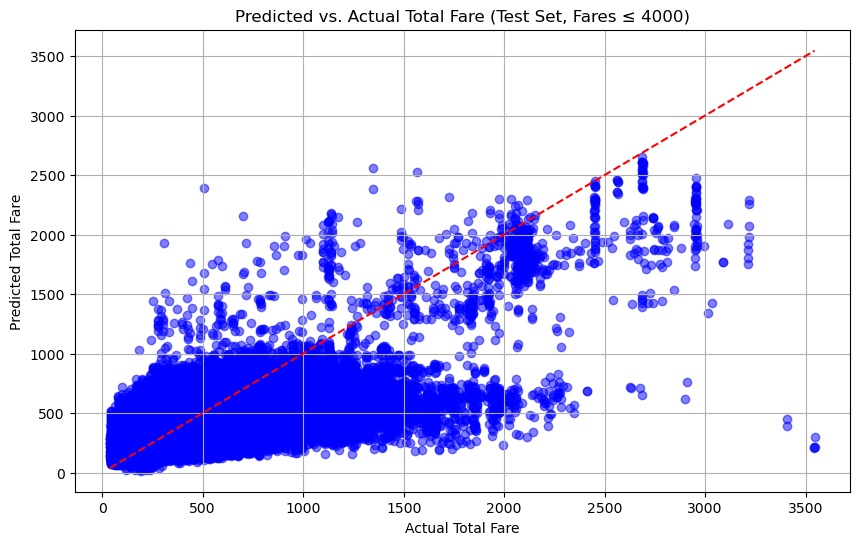

In [26]:
y_test = np.asarray(y_test).flatten()
test_pred = np.asarray(test_pred).flatten()

# Filter y_test and test_pred based on the condition for y_test values <= 4000
mask = y_test <= 4000
y_test_filtered = y_test[mask]
test_pred_filtered = test_pred[mask]

# Plot predicted vs. actual totalFare for the filtered test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, test_pred_filtered, color='blue', alpha=0.5)
plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Total Fare")
plt.ylabel("Predicted Total Fare")
plt.title("Predicted vs. Actual Total Fare (Test Set, Fares ≤ 4000)")
plt.grid(True)
plt.show()

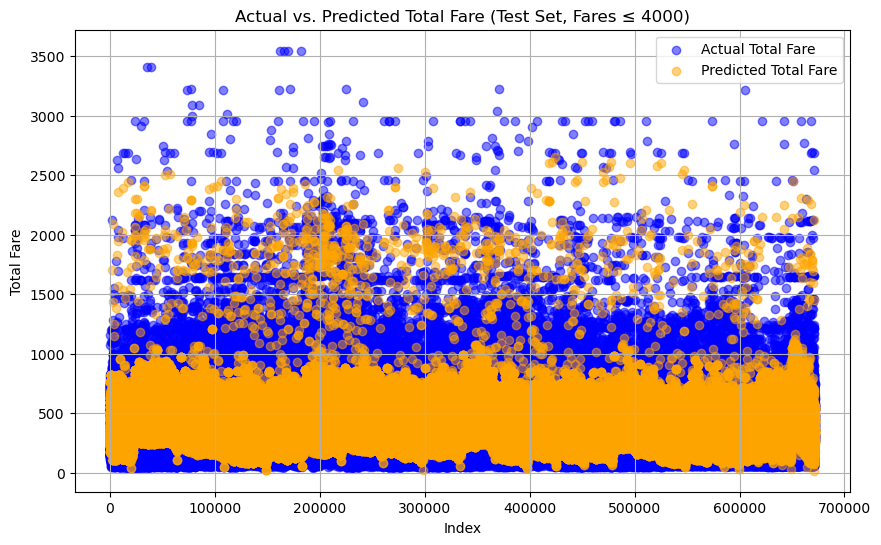

In [25]:
y_test = np.asarray(y_test).flatten()
test_pred = np.asarray(test_pred).flatten()

# Filter y_test and test_pred based on the condition for y_test values <= 4000
mask = y_test <= 4000
y_test_filtered = y_test[mask]
test_pred_filtered = test_pred[mask]

# Plot predicted vs. actual totalFare for the filtered test set
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_filtered)), y_test_filtered, color='blue', label="Actual Total Fare", alpha=0.5)
plt.scatter(range(len(test_pred_filtered)), test_pred_filtered, color='orange', label="Predicted Total Fare", alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Total Fare")
plt.title("Actual vs. Predicted Total Fare (Test Set, Fares ≤ 4000)")
plt.legend()
plt.grid(True)
plt.show()

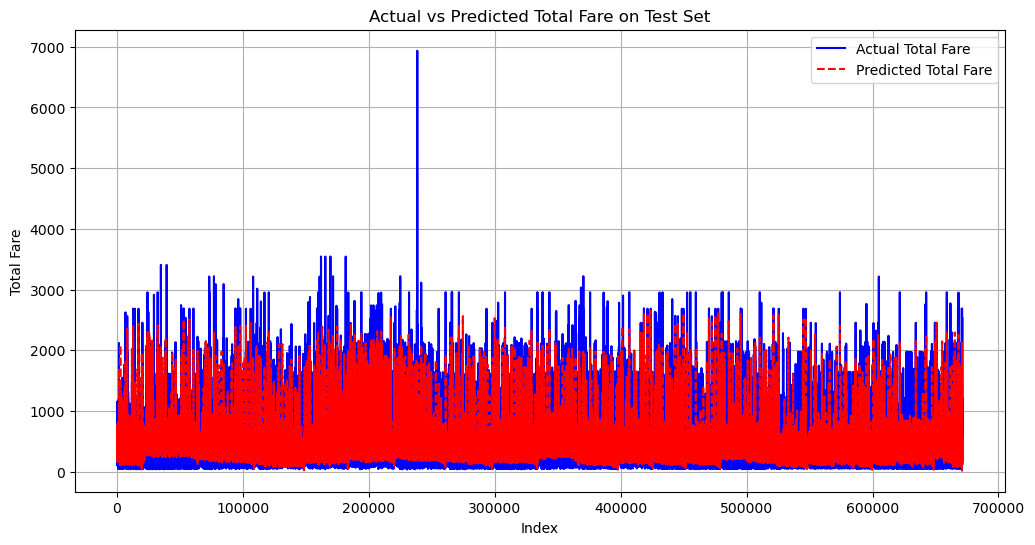

In [20]:
# Plot actual vs. predicted totalFare values with index on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Total Fare", color="blue", linestyle="-")
plt.plot(test_pred, label="Predicted Total Fare", color="red", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Total Fare")
plt.title("Actual vs Predicted Total Fare on Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Define categorical columns to be one-hot encoded, including date-related columns
categorical_cols = ['startingAirport', 'destinationAirport', 'cabin_type', 'month', 'day', 'hour', 'minute']

# Define preprocessor for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep the other features (like numerical ones) as they are
)

# Define XGBoost pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Fit the model on training data
model_pipeline.fit(X_train, y_train)

# Predict on train, validation, and test sets
train_pred = model_pipeline.predict(X_train)
val_pred = model_pipeline.predict(X_val)
test_pred = model_pipeline.predict(X_test)

# Calculate RMSE and MAE for each set
metrics = {
    'Train RMSE': mean_squared_error(y_train, train_pred, squared=False),
    'Train MAE': mean_absolute_error(y_train, train_pred),
    'Validation RMSE': mean_squared_error(y_val, val_pred, squared=False),
    'Validation MAE': mean_absolute_error(y_val, val_pred),
    'Test RMSE': mean_squared_error(y_test, test_pred, squared=False),
    'Test MAE': mean_absolute_error(y_test, test_pred)
}

# Print out metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Train RMSE: 141.17
Train MAE: 96.38
Validation RMSE: 176.31
Validation MAE: 124.37
Test RMSE: 161.36
Test MAE: 117.55


In [36]:
# Cyclical encoding for time features (hour and month)
def encode_cyclical_features(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute'])  # Drop raw datetime features after encoding
    return df

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['startingAirport', 'destinationAirport', 'cabin_type']),
        ('cyclical', FunctionTransformer(encode_cyclical_features), ['year', 'month', 'day', 'hour', 'minute'])
    ], remainder='passthrough'
)

# Define pipeline with preprocessing and CatBoost model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0))
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Predictions
train_pred = pipeline.predict(X_train)
val_pred = pipeline.predict(X_val)
test_pred = pipeline.predict(X_test)

# Calculate and print RMSE and MAE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

train_rmse, train_mae = calculate_metrics(y_train, train_pred)
val_rmse, val_mae = calculate_metrics(y_val, val_pred)
test_rmse, test_mae = calculate_metrics(y_test, test_pred)

print(f"Training Set - RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print(f"Validation Set - RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
print(f"Test Set - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")

Training Set - RMSE: 154.23, MAE: 106.98
Validation Set - RMSE: 168.12, MAE: 114.38
Test Set - RMSE: 156.46, MAE: 110.96


In [14]:
# Create a smaller subset for hyperparameter tuning
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)  # 80% for training, 20% for testing

# Cyclical encoding for time features (hour and month)
def encode_cyclical_features(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute'])  # Drop raw datetime features after encoding
    return df

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['startingAirport', 'destinationAirport', 'cabin_type']),
        ('cyclical', FunctionTransformer(encode_cyclical_features), ['year', 'month', 'day', 'hour', 'minute'])
    ], remainder='passthrough'
)

# Function to optimize
def objective(params):
    # Set default parameters
    params['max_depth'] = int(params['max_depth'])  # Ensure max_depth is an integer
    params['n_estimators'] = int(params['n_estimators'])  # Ensure n_estimators is an integer
    
    # Define model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42
    )

    # Create a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgb', model)
    ])
    
    # Fit pipeline on the subset of training data
    pipeline.fit(X_subset, y_subset)
    
    # Predictions
    val_pred = pipeline.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    return {'loss': rmse, 'status': STATUS_OK}

# Define search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform('max_depth', 4, 12, 1),  # Integer values from 4 to 12
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),  # Integer values from 100 to 500
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

# Trials object to track results
trials = Trials()

# Optimize using Hyperopt with only 20 evaluations
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Output the best hyperparameters
print("Best Hyperparameters:", best)

# After finding the best parameters, you can retrain your model with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=best['learning_rate'],
        max_depth=int(best['max_depth']),
        n_estimators=int(best['n_estimators']),
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        random_state=42
    ))
])

# Fit the best model on the full training data
best_pipeline.fit(X_train, y_train)

# Predictions
train_pred = best_pipeline.predict(X_train)
val_pred = best_pipeline.predict(X_val)
test_pred = best_pipeline.predict(X_test)

# Calculate and print RMSE and MAE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

train_rmse, train_mae = calculate_metrics(y_train, train_pred)
val_rmse, val_mae = calculate_metrics(y_val, val_pred)
test_rmse, test_mae = calculate_metrics(y_test, test_pred)

print(f"Training Set - RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print(f"Validation Set - RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
print(f"Test Set - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")

100%|█████████| 20/20 [07:29<00:00, 22.49s/trial, best loss: 166.19211674774192]
Best Hyperparameters: {'colsample_bytree': 0.9112046961874785, 'learning_rate': 0.12635038902243934, 'max_depth': 11.0, 'n_estimators': 167.0, 'subsample': 0.8805835345269344}
Training Set - RMSE: 149.84, MAE: 103.33
Validation Set - RMSE: 164.27, MAE: 111.21
Test Set - RMSE: 154.21, MAE: 108.64


In [15]:
dump(best_pipeline,  '../models/xgboost_hyperopt.joblib')

['../models/xgboost_hyperopt.joblib']

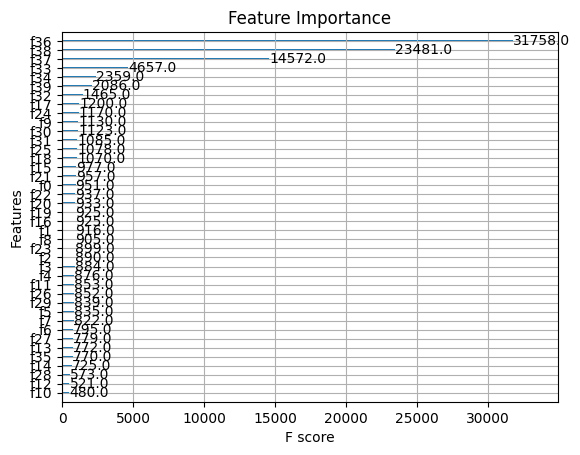

In [16]:
model = best_pipeline.named_steps['xgb']

# Plot feature importances
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [18]:
X_test.head()

,startingAirport,destinationAirport,cabin_type,year,month,day,hour,minute
0,DTW,LGA,coach,2022,6,21,12,15
1,DTW,LAX,coach,2022,6,21,12,15
2,EWR,DEN,coach,2022,6,21,12,15
3,ORD,CLT,coach,2022,6,21,12,15
4,DTW,LAX,coach,2022,6,21,12,15


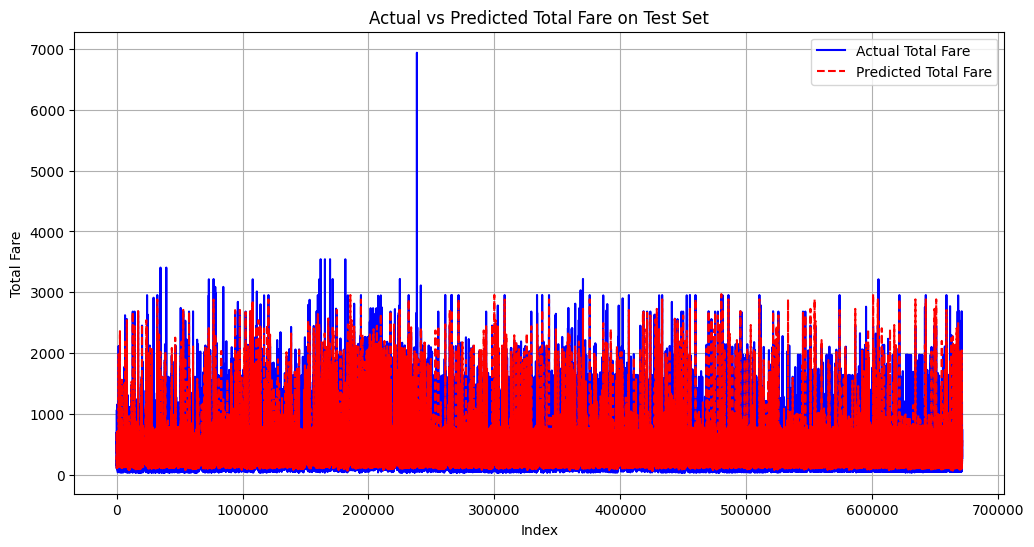

In [19]:
# Plot actual vs. predicted totalFare values with index on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Total Fare", color="blue", linestyle="-")
plt.plot(test_pred, label="Predicted Total Fare", color="red", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Total Fare")
plt.title("Actual vs Predicted Total Fare on Test Set")
plt.legend()
plt.grid(True)
plt.show()